In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from neural_astar.planner import NeuralAstar
from neural_astar.utils.data import create_warcraft_dataloader
from neural_astar.utils.training import load_from_ptl_checkpoint

/home/yonetani/programs/omron-sinicx/neural-astar/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataloader = create_warcraft_dataloader("../12x12/", "test", 10)
map_designs, start_maps, goal_maps, opt_trajs = next(iter(dataloader))

In [3]:
model = NeuralAstar(encoder_input="rgb+", encoder_arch="CNNDownSize", encoder_depth=3, learn_obstacles=True, Tmax=1.0, const=10.)
model.load_state_dict(load_from_ptl_checkpoint("../model/12x12/lightning_logs"))

load ../model/12x12/lightning_logs/version_0/checkpoints/epoch=14-step=1500.ckpt


<All keys matched successfully>

In [4]:
outputs = model(map_designs, start_maps, goal_maps)

/home/yonetani/programs/omron-sinicx/neural-astar/.venv/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
cost_maps = model.encode(map_designs, start_maps, goal_maps)

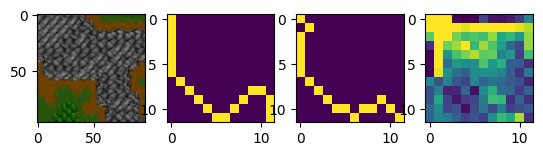

In [6]:
t = 4
plt.subplot(1, 4, 1)
plt.imshow(map_designs[t].permute(1, 2, 0))
plt.subplot(1, 4, 2)
plt.imshow(opt_trajs[t, 0])
plt.subplot(1, 4, 3)
plt.imshow(outputs.paths[t, 0])
plt.subplot(1, 4, 4)
plt.imshow(cost_maps[t, 0].detach(), vmax=5.0)